# Modeling and Evaluation

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
import numpy as np
import mlflow
import plotly.express as px

## Functions

In [2]:
def plot_precision_recall(y_true, y_pred, algorithm_name = 'foo'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

    fig = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(recall, precision):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.write_image(f'images/precision_recall_{algorithm_name}.png')
    #fig.show()

In [3]:
def get_confusion_matrix_metrics(y_test, y_pred):
    array = confusion_matrix(y_test, y_pred)
    tn = array[0, 0]
    fn = array[1, 0]
    fp = array[0, 1]
    tp = array[1, 1]

    err = ((fp+fn)/(tp+tn+fn+fp))*100
    acc = ((tp+tn)/(tp+tn+fn+fp))*100
    tpr = ((tp)/(tp+fn))*100
    tnr = ((tn)/(tn+fp))*100
    fnr = ((fn)/(tp+fn))*100
    fpr = ((fp)/(tn+fp))*100

    return err, acc, tpr, tnr, fnr, fpr

## Get data

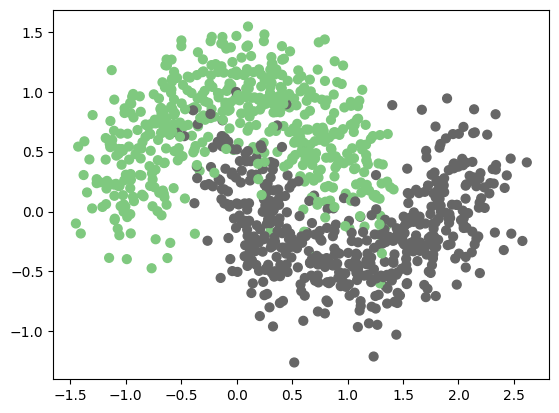

In [4]:
n = 1000
test_size = 0.25
data_seed = 73 

X, y = datasets.make_moons(
    n_samples = n, 
    noise = 0.25, 
    random_state = data_seed)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = test_size,
    random_state = 42)

plt.scatter(
    x = X[:,0], 
    y = X[:,1], 
    s = 40, 
    c = y, 
    cmap = plt.cm.Accent);

## Run the  experiment

In [5]:
mlflow.set_experiment("Moon Classification")
mlflow.autolog()

target_names = ['0', '1']

2024/01/20 00:13:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/20 00:13:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


### Random Forest

In [6]:
with mlflow.start_run(run_name='random_forest_model') as run:
    model_rf = RandomForestClassifier(random_state = 42, n_estimators=2)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)

    # metrics
    precision_0 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["0"]["precision"]

    recall_0 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["0"]["recall"]

    f1_score_0 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["0"]["f1-score"]

    precision_1 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["1"]["precision"]

    recall_1 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["1"]["recall"]

    f1_score_1 = classification_report(
    y_true=y_test, 
    y_pred=y_pred, 
    target_names=target_names, 
    output_dict=True)["1"]["f1-score"]
    
    err, acc, tpr, tnr, fnr, fpr = get_confusion_matrix_metrics(y_test=y_test, y_pred=y_pred)
    
    # log metrics
    mlflow.log_metric("precision_0", precision_0)
    mlflow.log_metric("recall_0", recall_0)
    mlflow.log_metric("f1_score_0", f1_score_0)
    mlflow.log_metric("precision_1", precision_1)
    mlflow.log_metric("recall_1", recall_1)
    mlflow.log_metric("f1_score_1", f1_score_1)
    
    mlflow.log_metric("err", err)
    mlflow.log_metric("acc", acc)
    mlflow.log_metric("tpr", tpr)
    mlflow.log_metric("tnr", tnr)
    mlflow.log_metric("fnr", fnr)
    mlflow.log_metric("fpr", fpr)
    
    algorithm_name = "rf"
    plot_precision_recall(y_test, y_pred, algorithm_name=algorithm_name)
    mlflow.log_artifact(f"images/precision_recall_{algorithm_name}.png")
    
    mlflow.log_artifact("logging_example.ipynb")

2024/01/20 00:14:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
